
# Action Masking in the Taxi Environment

Action masking improve reinforcement learning performance by preventing invalid actions.

The Taxi environment has 6 possible actions:

- 0: Move south (down)
- 1: Move north (up)
- 2: Move east (right)
- 3: Move west (left)
- 4: Pickup passenger
- 5: Drop off passenger

The environment provides an ``action_mask`` in the info dictionary returned by ``reset()`` and ``step()``.
This mask is a binary array where 1 indicates a valid action and 0 indicates an invalid action.

Action masking works by constraining the agent's action selection to only valid actions:

1. During exploration: When selecting random actions, we only choose from the set of valid actions
2. During exploitation: When selecting the best action based on Q-values, we only consider Q-values for valid actions
3. During Q-learning updates: We compute the maximum future Q-value only over valid actions in the next state

In [2]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

import gymnasium as gym

BASE_RANDOM_SEED = 42


def train_q_learning(
    env,
    use_action_mask: bool = True,
    episodes: int = 5000,
    seed: int = BASE_RANDOM_SEED,
    learning_rate: float = 0.1,
    discount_factor: float = 0.95,
    epsilon: float = 0.1,
) -> dict:
    """Train a Q-learning agent with or without action masking."""
    # Set random seeds for reproducibility
    np.random.seed(seed)
    random.seed(seed)

    # Initialize Q-table
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    q_table = np.zeros((n_states, n_actions))

    # Track episode rewards for analysis
    episode_rewards = []

    for episode in range(episodes):
        # Reset environment
        state, info = env.reset(seed=seed + episode)
        total_reward = 0
        terminated = False
        truncated = False

        while not (terminated or truncated):
            # Get action mask if using it
            action_mask = info["action_mask"] if use_action_mask else None

            # Epsilon-greedy action selection with masking
            if np.random.random() < epsilon:
                # Random action selection
                if use_action_mask:
                    # Only select from valid actions
                    valid_actions = np.nonzero(action_mask == 1)[0]
                    action = np.random.choice(valid_actions)
                else:
                    # Select from all actions
                    action = np.random.randint(0, n_actions)
            else:
                # Greedy action selection
                if use_action_mask:
                    # Only consider valid actions for exploitation
                    valid_actions = np.nonzero(action_mask == 1)[0]
                    if len(valid_actions) > 0:
                        action = valid_actions[np.argmax(q_table[state, valid_actions])]
                    else:
                        action = np.random.randint(0, n_actions)
                else:
                    # Consider all actions
                    action = np.argmax(q_table[state])

            # Take action and observe result
            next_state, reward, terminated, truncated, info = env.step(action)
            total_reward += reward

            # Q-learning update
            if not (terminated or truncated):
                if use_action_mask:
                    # Only consider valid next actions for bootstrapping
                    next_mask = info["action_mask"]
                    valid_next_actions = np.nonzero(next_mask == 1)[0]
                    if len(valid_next_actions) > 0:
                        next_max = np.max(q_table[next_state, valid_next_actions])
                    else:
                        next_max = 0
                else:
                    # Consider all next actions
                    next_max = np.max(q_table[next_state])

                # Update Q-value
                q_table[state, action] = q_table[state, action] + learning_rate * (
                    reward + discount_factor * next_max - q_table[state, action]
                )

            state = next_state

        episode_rewards.append(total_reward)

    return {
        "episode_rewards": episode_rewards,
        "mean_reward": np.mean(episode_rewards),
        "std_reward": np.std(episode_rewards),
    }

# Running the Experiment

- 12 independent runs with different random seeds to ensure robust statistical comparison.
- 5000 episodes per run
- Standard Q-learning hyperparameters ``(α=0.1, γ=0.95, ε=0.1)``

In [3]:
# Experiment parameters
n_runs = 12
episodes = 5000
learning_rate = 0.1
discount_factor = 0.95
epsilon = 0.1

# Generate different seeds for each run
seeds = [BASE_RANDOM_SEED + i for i in range(n_runs)]

# Store results for comparison
masked_results_list = []
unmasked_results_list = []

# Run experiments with different seeds
for i, seed in enumerate(seeds):
    print(f"Run {i + 1}/{n_runs} with seed {seed}")

    # Train agent WITH action masking
    env_masked = gym.make("Taxi-v3")
    masked_results = train_q_learning(
        env_masked,
        use_action_mask=True,
        seed=seed,
        learning_rate=learning_rate,
        discount_factor=discount_factor,
        epsilon=epsilon,
        episodes=episodes,
    )
    env_masked.close()
    masked_results_list.append(masked_results)

    # Train agent WITHOUT action masking
    env_unmasked = gym.make("Taxi-v3")
    unmasked_results = train_q_learning(
        env_unmasked,
        use_action_mask=False,
        seed=seed,
        learning_rate=learning_rate,
        discount_factor=discount_factor,
        epsilon=epsilon,
        episodes=episodes,
    )
    env_unmasked.close()
    unmasked_results_list.append(unmasked_results)

Run 1/12 with seed 42
Run 2/12 with seed 43
Run 3/12 with seed 44
Run 4/12 with seed 45
Run 5/12 with seed 46
Run 6/12 with seed 47
Run 7/12 with seed 48
Run 8/12 with seed 49
Run 9/12 with seed 50
Run 10/12 with seed 51
Run 11/12 with seed 52
Run 12/12 with seed 53


# Visualizing Results

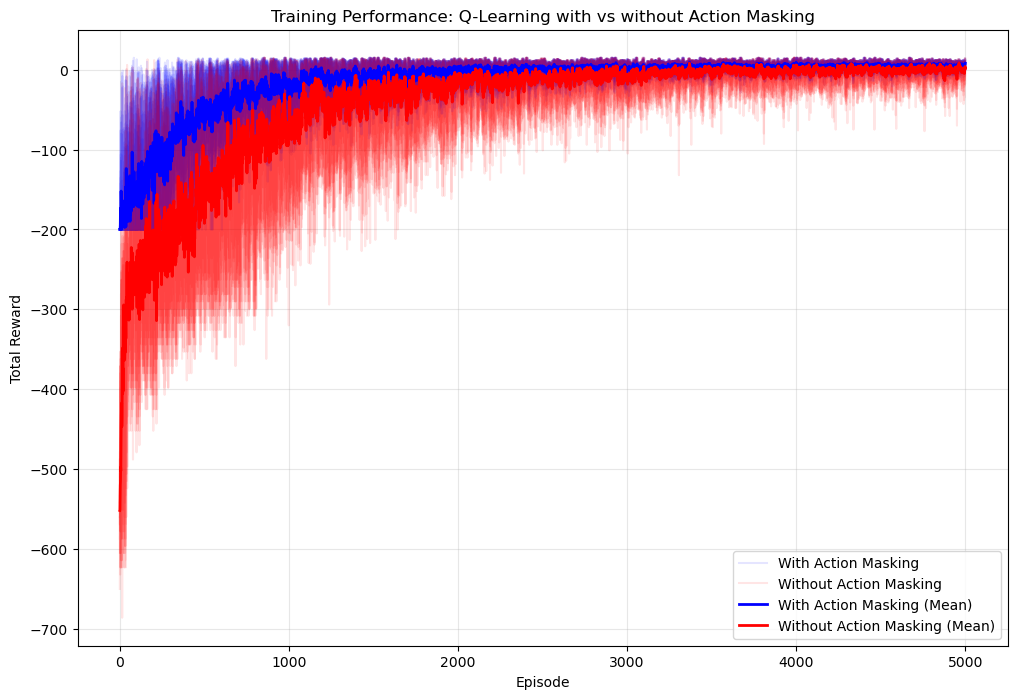

In [4]:
# Calculate statistics across runs
masked_mean_rewards = [r["mean_reward"] for r in masked_results_list]
unmasked_mean_rewards = [r["mean_reward"] for r in unmasked_results_list]

masked_overall_mean = np.mean(masked_mean_rewards)
masked_overall_std = np.std(masked_mean_rewards)
unmasked_overall_mean = np.mean(unmasked_mean_rewards)
unmasked_overall_std = np.std(unmasked_mean_rewards)

# Create visualization
plt.figure(figsize=(12, 8), dpi=100)

# Plot individual runs with low alpha
for i, (masked_results, unmasked_results) in enumerate(
    zip(masked_results_list, unmasked_results_list)
):
    plt.plot(
        masked_results["episode_rewards"],
        label="With Action Masking" if i == 0 else None,
        color="blue",
        alpha=0.1,
    )
    plt.plot(
        unmasked_results["episode_rewards"],
        label="Without Action Masking" if i == 0 else None,
        color="red",
        alpha=0.1,
    )

# Calculate and plot mean curves across all runs
masked_mean_curve = np.mean([r["episode_rewards"] for r in masked_results_list], axis=0)
unmasked_mean_curve = np.mean(
    [r["episode_rewards"] for r in unmasked_results_list], axis=0
)

plt.plot(
    masked_mean_curve, label="With Action Masking (Mean)", color="blue", linewidth=2
)
plt.plot(
    unmasked_mean_curve,
    label="Without Action Masking (Mean)",
    color="red",
    linewidth=2,
)

plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Training Performance: Q-Learning with vs without Action Masking")
plt.legend()
plt.grid(True, alpha=0.3)

# Save the figure
savefig_folder = Path("_static/img/tutorials/")
savefig_folder.mkdir(parents=True, exist_ok=True)
plt.savefig(
    savefig_folder / "taxi_v3_action_masking_comparison.png",
    bbox_inches="tight",
    dpi=150,
)
plt.show()

# Results Analysis

The comparison demonstrates several important benefits of using action masking:

Key Benefits of Action Masking:

1. Faster Convergence: Agents with action masking typically learn faster because they don't waste time exploring
invalid actions.

2. Better Performance: By focusing only on valid actions, the agent can achieve higher rewards more consistently.

3. More Stable Learning: Action masking reduces the variance in learning by eliminating the randomness associated with invalid action selection.

4. Practical Applicability: In real-world scenarios, action masking prevents agents from taking actions that could be dangerous or impossible.